In [1]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available

True


In [3]:
import sys
from pathlib import Path

# Caminho para a pasta src/ (um nível acima de notebooks/)
root_dir = Path.cwd().parent
src_dir = root_dir / "src"

# Adiciona src/ ao sys.path
sys.path.append(str(src_dir))

# Agora o import deve funcionar
from utils.image_utils import load_image, show_pair
from inference.classifier import classify_document

In [4]:
from data.documentpairs import DocumentPairDataset

dataset = DocumentPairDataset(
    csv_path="../../once_learning_dataset/once_learning_pairs_balanceado.csv",
    base_dir="../../once_learning_dataset/images",
    input_size=448,
    max_num=12,
    device="cuda"
)

In [5]:
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from sklearn.metrics import roc_curve
from PIL import Image
from scipy.spatial.distance import cosine

# --- Função Auxiliar para Carregar e Preparar a Imagem ---
def load_and_flatten_image(image_path, target_size=(224, 224)):
    """
    Carrega uma imagem, converte para escala de cinza, redimensiona
    e a achata em um vetor 1D.

    Args:
        image_path (str): O caminho para o arquivo de imagem.
        target_size (tuple): O tamanho (largura, altura) para redimensionar a imagem.

    Returns:
        np.array: Um vetor 1D representando os pixels da imagem.
    """
    try:
        # Abre a imagem e converte para escala de cinza ('L') para simplificar
        with Image.open(image_path).convert('L') as img:
            # Redimensiona para um tamanho padrão
            img_resized = img.resize(target_size)
            # Converte para um array NumPy e o achata em um vetor 1D
            return np.array(img_resized).flatten()
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        # Retorna um vetor de zeros com o tamanho esperado em caso de erro
        return np.zeros(target_size[0] * target_size[1])


In [ ]:
# --- Código Principal de Avaliação ---

# Definição de um tamanho padrão para todas as imagens
TARGET_IMAGE_SIZE = (224, 224)

distances = []
labels = []
inference_times = []

# ======================= LOOP PRINCIPAL =======================
for i in range(len(dataset)):
    row = dataset.df.iloc[i]
    label = int(row["is_equal"])

    reference_image_path = os.path.join(dataset.base_dir, row["file_a_path"])
    image_path           = os.path.join(dataset.base_dir, row["file_b_path"])

    start_time = time.time()

    # Carrega e prepara os vetores de pixel para ambas as imagens
    vector_A = load_and_flatten_image(reference_image_path, target_size=TARGET_IMAGE_SIZE)
    vector_B = load_and_flatten_image(image_path, target_size=TARGET_IMAGE_SIZE)
    
    # Calcula a distância de cosseno.
    # A distância de cosseno é definida como 1 - similaridade de cosseno.
    # Um valor próximo de 0 significa muito similar; próximo de 1 significa muito diferente.
    distance = cosine(vector_A, vector_B)
    
    inference_time = time.time() - start_time
    inference_times.append(inference_time)
    
    distances.append(distance)
    labels.append(label)


/home/joaopaulo/envs/pytorch/lib/python3.11/site-packages/scipy/spatial/distance.py:685: RuntimeWarning: overflow encountered in scalar multiply
  dist = 1.0 - uv / math.sqrt(uu * vv)
/home/joaopaulo/envs/pytorch/lib/python3.11/site-packages/scipy/spatial/distance.py:685: RuntimeWarning: divide by zero encountered in divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


In [13]:
distances = np.array(distances)
labels = np.array(labels)

# Inverter o sinal da distância para usar como "score" (menor = mais similar)
fpr, tpr, thresholds = roc_curve(labels, -distances)
fnr = 1 - tpr

eer_index = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_index]
eer_threshold = thresholds[eer_index]

print(f"EER: {eer:.4f} (threshold: {eer_threshold:.4f})")

EER: 0.9781 (threshold: -0.0000)


In [10]:
# === Calcular EER ===
distances = np.array(distances)
labels = np.array(labels)

# Para a distância de cosseno, menor é melhor, então não invertemos o sinal
fpr, tpr, thresholds = roc_curve(labels, distances) 
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_index]
eer_threshold = thresholds[eer_index]

# === Dados de performance ===
avg_inference_time   = np.mean(inference_times)

/tmp/ipykernel_28792/3104744584.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dist_iguais, label="Pares Iguais", shade=True, color="blue")
/tmp/ipykernel_28792/3104744584.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dist_diferentes, label="Pares Diferentes", shade=True, color="red")


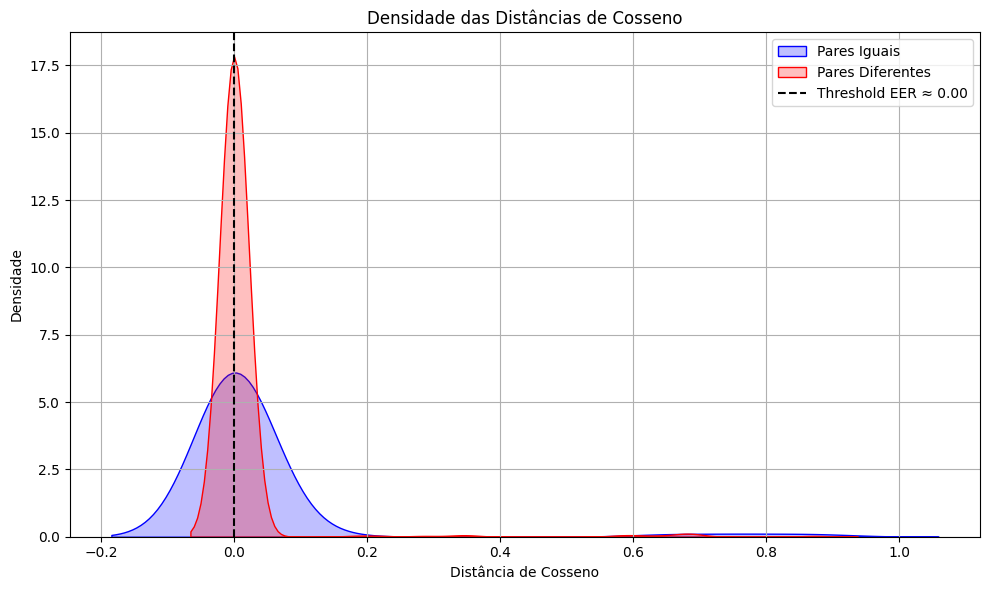

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Certifique-se de que distances e labels estão como np.array
distances = np.array(distances)
labels = np.array(labels)

# Separar os dados
dist_iguais = distances[labels == 1]
dist_diferentes = distances[labels == 0]

# Calcular o EER novamente para obter o threshold (caso não tenha salvo)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(labels, -distances)  # negativo porque menor distância = mais similar
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_index]
eer_threshold = thresholds[eer_index]

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(dist_iguais, label="Pares Iguais", shade=True, color="blue")
sns.kdeplot(dist_diferentes, label="Pares Diferentes", shade=True, color="red")
plt.axvline(x=-eer_threshold, color='black', linestyle='--', label=f"Threshold EER ≈ {-eer_threshold:.2f}")
plt.title("Densidade das Distâncias de Cosseno")
plt.xlabel("Distância de Cosseno")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()